In [1]:
#Importing libraries
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.tools.jupyter import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Initial Values and Parameters

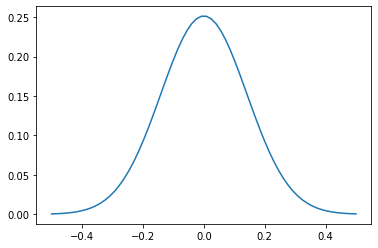

In [2]:
#DEFINE INITIAL WAVEFUNCTION

L = 0.5 #width of square well
n = 6 #number of qubits
x = np.linspace(-L, L, num=2**n) #number of x points

wvfunc = np.exp(-25*x**2) #Initial wavefunciton
Normalisation_Constant = np.sqrt(np.sum(wvfunc**2)) 
normalized_wvfunc = wvfunc / Normalisation_Constant ##Normalized initial wavefunction

plt.plot(x, normalized_wvfunc)
plt.show()

In [3]:
#DEFINE PARAMETERS

qubit_num = n #number of qubits
qubit_tot = 2**qubit_num #number of possible states
dt = 0.001 #timestep
v = 100 #potential within the system (v1, v0=0)
iteration = 50 #number of iteration
t = iteration*dt #time evolution
ALPHA = -(2*np.pi*qubit_tot)**2 * dt

# QFT and Inverse QFT

In [4]:
def rotate_qft(circuit, register, n):
    """
    Performs QFT on the first n qubits in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform QFT on circuit
    """

    if n == 0:
        return circuit
    
    n = n - 1
    circuit.h(register[n])
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), register[qubit], register[n])
        
    rotate_qft(circuit, register, n)
    
def swap_registers(circuit, register, n):
    """
    Swaps qubits to match QFT definition
    Args:
        circuit, register, number of qubits
    Returns:
        Swaps two qubits
    """
    
    for qubit in range(n//2):
        circuit.swap(register[qubit], register[n-qubit-1])
        
    return circuit

def qft(circuit, register, n):
    """
    Performs QFT in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform QFT (rotations and swaps) on circuit
    """    
    
    rotate_qft(circuit, register, n)
    swap_registers(circuit, register, n)
    
    return circuit

def inverse_qft(circuit, register, n):
    """
    Performs inverse of QFT in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform inverse of QFT on circuit
    """
    
    reg = QuantumRegister(n)
    qc = QuantumCircuit(reg)
    qft_circuit = qft(qc, reg, n)
    invqft = qft_circuit.inverse()
    circuit = circuit.compose(invqft, register)
    
    return circuit

# Time Evolution Operator

In [5]:
def potential(circuit, register, n):
    """
    Define potential operator within the systems
    Args:
        circuit, register, number of qubits
    Returns:
        Add potential to the circuit
    """
    pot = -dt*v
    
    i = 0 + 1j
    potential_matrix = np.array([[np.exp(i*pot), 0], [0, np.exp(i*pot)]])
    potential_gate = UnitaryGate(potential_matrix)

    #Create Potential unitary gate
    qcc = QuantumCircuit(1)
    qcc.append(potential_gate, [0])
    potgate = qcc.to_gate(label='Potential').control(1)

    circuit.x(register[n-2])
    circuit.cx(register[n-2], register[n-1])
    circuit.x(register[n-2])

    circuit.x(register[n-1])
    circuit.append(potgate, [register[n-1], register[n-2]])

    circuit.x(register[n-1])

    circuit.x(register[n-2])
    circuit.cx(register[n-2], register[n-1])
    circuit.x(register[n-2])
    
    return circuit

In [6]:
def constant_phase(circuit, register):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    i = 0 + 1j
    constant_phase = np.array([[np.exp(i*ALPHA/4), 0], [0, np.exp(i*ALPHA/4)]])
    cp_gate = UnitaryGate(constant_phase, 'Constant')
    circuit.append(cp_gate, [register[0]])
    circuit.barrier()
    
    return circuit

def rotate1(circuit, register, n):
    """
    Add shift phase gate to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = -ALPHA * 2**(m-n)
        circuit.p(theta, register[m])
        
    return circuit


def rotate2(circuit, register, n):
    """
    Add constant phase to the circuit
    Args:
        circuit, register, number of qubits
    """
    
    for m in range(n):
        theta = ALPHA * 2**(2*(m-n))
        circuit.p(theta, register[m])
        
    return circuit

def kinetic(circuit, register, qubit):
    """
    Define energy kinetic operator
    Args:
        circuit, register, number of qubits
    Returns:
        Add energy kinetics to the system
    """
    
    constant_phase(circuit, register)
    rotate1(circuit, register, qubit)
    rotate2(circuit, register, qubit)
    
    n = np.arange(qubit-1, -1, -1, dtype=float)
    
    for i in n:
        for j in np.arange(i-1, -1, -1, dtype=float):
            kin = 2*ALPHA*2**(j + i - 2*(len(n)))
            circuit.cp(kin, register[int(j)], register[int(i)])
            
    return circuit

# Probability Density Simulation

In [7]:
#Create n qubits quantum registers and quantum circuit

work_reg = QuantumRegister(qubit_num, 'qw') #Work register
sim_reg = QuantumRegister(qubit_num, 'qs') #Simulation register
clas_reg = ClassicalRegister(qubit_num, 'c') #Classical register (for measurement)
circuit = QuantumCircuit(work_reg, sim_reg, clas_reg) #Quantum circuit

#Apply Hadamard gate on work register
circuit.h(work_reg)

#INITIALIZATION
circuit.initialize(normalized_wvfunc, sim_reg)
circuit.barrier()

#Perform time evolution operator
for i in range(iteration):
    #POTENTIAL
    potential(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #QFT
    qft(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #KINETIC
    kinetic(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #INVERS QFT
    circuit = inverse_qft(circuit, sim_reg, qubit_num)
    circuit.barrier()


    #POTENTIAL
    potential(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #QFT
    qft(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #KINETIC
    kinetic(circuit, sim_reg, qubit_num)
    circuit.barrier()

    #INVERS QFT
    circuit = inverse_qft(circuit, sim_reg, qubit_num)
    circuit.barrier()


#Perform Quantum Phase Estimation Algorithm - to estimate phase (eigen energy)
guessed_energy = 0.1
angle = (guessed_energy) / 2*np.pi
for work_qubit in range(0, qubit_num):
    repetitions = 2**work_qubit
    for sim_qubit in range(0, qubit_num):
        for i in range(repetitions):
            circuit.cp(angle, work_reg[work_qubit], sim_reg[sim_qubit])

circuit.barrier()

#Invers QFT on work register
circuit = inverse_qft(circuit, work_reg, qubit_num)
circuit.barrier()

#Measurement - Comment and uncomment for measuring simulation and work register
circuit.measure(sim_reg, clas_reg) #Measure simulation register - probability density
# circuit.measure(work_reg, clas_reg) #Measure working register - estimate phase to count energy

#Uncomment to draw quantum circuit
#More iteration -> more complex circuit -> more time it takes to load
# circuit.draw()

#Uncomment to save quantum circuit
# circuit.draw().savefig('quantum-circuit', dpi=500)

# Energy Simulation

In [8]:
#Create n qubits quantum registers and quantum circuit

work_reg = QuantumRegister(qubit_num, 'qw') #Work register
sim_reg = QuantumRegister(qubit_num, 'qs') #Simulation register
clas_reg = ClassicalRegister(qubit_num, 'c') #Classical register (for measurement)
circuit2 = QuantumCircuit(work_reg, sim_reg, clas_reg) #Quantum circuit

#Apply Hadamard gate on work register
circuit2.h(work_reg)

#INITIALIZATION
circuit2.initialize(normalized_wvfunc, sim_reg)
circuit2.barrier()

#Perform time evolution operator
for i in range(iteration):
    #POTENTIAL
    potential(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    #QFT
    qft(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    #KINETIC
    kinetic(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    #INVERS QFT
    circuit2 = inverse_qft(circuit2, sim_reg, qubit_num)
    circuit2.barrier()


    #POTENTIAL
    potential(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    # QFT
    qft(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    #KINETIC
    kinetic(circuit2, sim_reg, qubit_num)
    circuit2.barrier()

    #INVERS QFT
    circuit2 = inverse_qft(circuit2, sim_reg, qubit_num)
    circuit2.barrier()


#Perform Quantum Phase Estimation Algorithm - to estimate phase (eigen energy)
guessed_energy = 0.1
angle = (guessed_energy) / 2*np.pi
for work_qubit in range(0, qubit_num):
    repetitions = 2**work_qubit
    for sim_qubit in range(0, qubit_num):
        for i in range(repetitions):
            circuit2.cp(angle, work_reg[work_qubit], sim_reg[sim_qubit])

circuit2.barrier()

#Invers QFT on work register
circuit2 = inverse_qft(circuit2, work_reg, qubit_num)
circuit2.barrier()

#Measurement - Comment and uncomment for measuring simulation and work register
# circuit2.measure(sim_reg, clas_reg) #Measure simulation register - probability density
circuit2.measure(work_reg, clas_reg) #Measure working register - estimate phase to count energy

#Uncomment to draw quantum circuit
#More iteration -> more complex circuit -> more time it takes to load
# circuit2.draw()

#Uncomment to save quantum circuit
# circuit2.draw().savefig('quantum-circuit', dpi=500)

# Simulation

In [9]:
import time

start = time.time()
#Define backends
backend = BasicAer.get_backend('qasm_simulator')
shots = 10000 #number of samples used for statistics

#Probability density
job1 = backend.run(transpile(circuit, backend), shots=shots)
answer_prob = job1.result().get_counts(circuit)

#Energy
job2 = backend.run(transpile(circuit2, backend), shots=shots)
answer_en = job2.result().get_counts(circuit2)

end = time.time()
elapsed_time = end - start
print("Measurement is done...")
print("Elapsed time: ", elapsed_time)

Measurement is done...
Elapsed time:  35.22600340843201


# Simulation Results

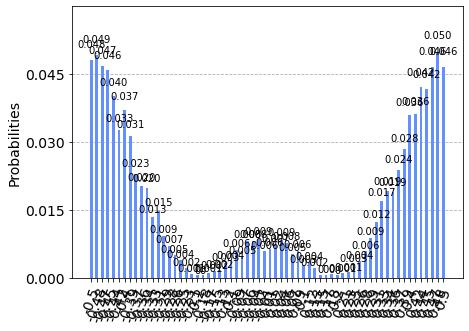

In [10]:
def get_histogram_decimal(result, xinterval, qubit):
    """
    Convert measurement result from qubit vs probability into position vs probability
    Args:
        result - dict: measurement result
        xinterval - list: the list of position used to calculate initial wavefunction
        qubit - int: number of qubit
    Return:
        dictionary of position:probability
    """

    answer_dec = {}
    for key, values in result.items():
        ans_dec = int(key, 2)
        answer_dec[ans_dec] = values
        
    posx = []
    for i in range(0, 2**qubit):
        if i in answer_dec.keys():
            posx.append(answer_dec[i])
            # ax[i] = new_dic[i]
        else:
            posx.append(0)
        
    new_dic = {}
    interval = [round(j, 2) for j in xinterval]
    for i in range(0, 2**qubit):
        new_dic[interval[i]] = posx[i]

    return new_dic

#Plot histograms
hist = get_histogram_decimal(answer_prob, x, qubit_num)

#Save probability density histogram
# title = "Probability Density \n iteration= {}, t= {} ".format(iteration, t)
# plot_histogram(hist).savefig('probdens-q'+str(qubit_num)+'-i'+str(iteration), dpi=500)

#Show probability density histograms
plot_histogram(hist) #, figsize=(20,10))

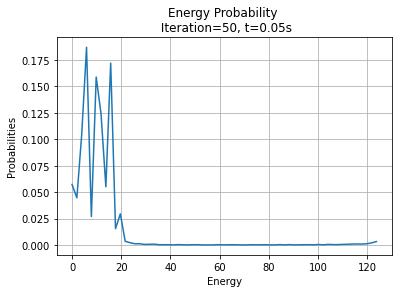

In [11]:
def calculates_energy(result, qubit, time):
    """
    Export phase and calculates energy from measurement result
    Args:
        result - dict: measurement result
        qubit - int: number of qubit
        time - int: simulation time (depends on iteration and dt)
    Return:
        lists of energy and probability
    """
    
    answer_dec = {}
    energy_estimated = {}
    
    for key, values in result.items():
        ans_dec = int(key, 2)
        answer_dec[ans_dec] = values
    
    for i in range(0, 2**qubit):
        if i not in answer_dec.keys():
            answer_dec[i] = 0
    
    for key, values in answer_dec.items():
        theta = key/2**qubit
        energy = 2*np.pi*theta / time
        energy_estimated[energy] = values
        
    energy = sorted(energy_estimated)
    probability = []
    for val in energy:
        for key in energy_estimated.keys():
            if val == key:
                prob = energy_estimated[key]/sum(energy_estimated.values())
                probability.append(prob)
                
    return energy, probability
        
en, prob = calculates_energy(answer_en, qubit_num, t)    
plt.plot(en, prob)
plt.xlabel('Energy')
plt.ylabel('Probabilities')
title = "Energy Probability \n Iteration={}, t={}s".format(iteration, t)
plt.title(title)
plt.grid()
# plt.savefig('enprob-q'+str(qubit_num)+'-i'+str(iteration), dpi=500)
plt.show()

In [12]:
def save_output(prob_dic, en, en_prob):
    """
    Save the result of measuremens in csv file
    Args:
        prob_dic - dict: measurement of probability density
        en - list: energy
        en_prob - list: probability of energy
    Return:
        csv file
    """
    
    dataframe = pd.DataFrame(columns=['Position', 'Probability', 'Energy', 'Energy Probability'])
    pos = list(prob_dic.keys())
    prob = []
    
    for key in prob_dic.keys():
        prob.append(prob_dic[key]/sum(prob_dic.values()))
        
    for i in range(len(prob)):
        dataframe.loc[i] = pos[i], prob[i], en[i], en_prob[i]
        
    return dataframe

filename = 'output-q{}-i{}'.format(qubit_num, iteration)
output = save_output(hist, en, prob)
# output.to_csv(filename, sep='\t', header=False, index=False)
print('Output saved...')

Output saved...
